In [1]:
import matplotlib.pyplot as plt
from morphocilia.io import load_rescaled_channel
from morphocilia.segmenter import cilia_segmenter_cleaner
from morphocilia.quantifier import cilia_props_table
import napari
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
from skimage.io import imread
from skimage.measure import regionprops_table
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


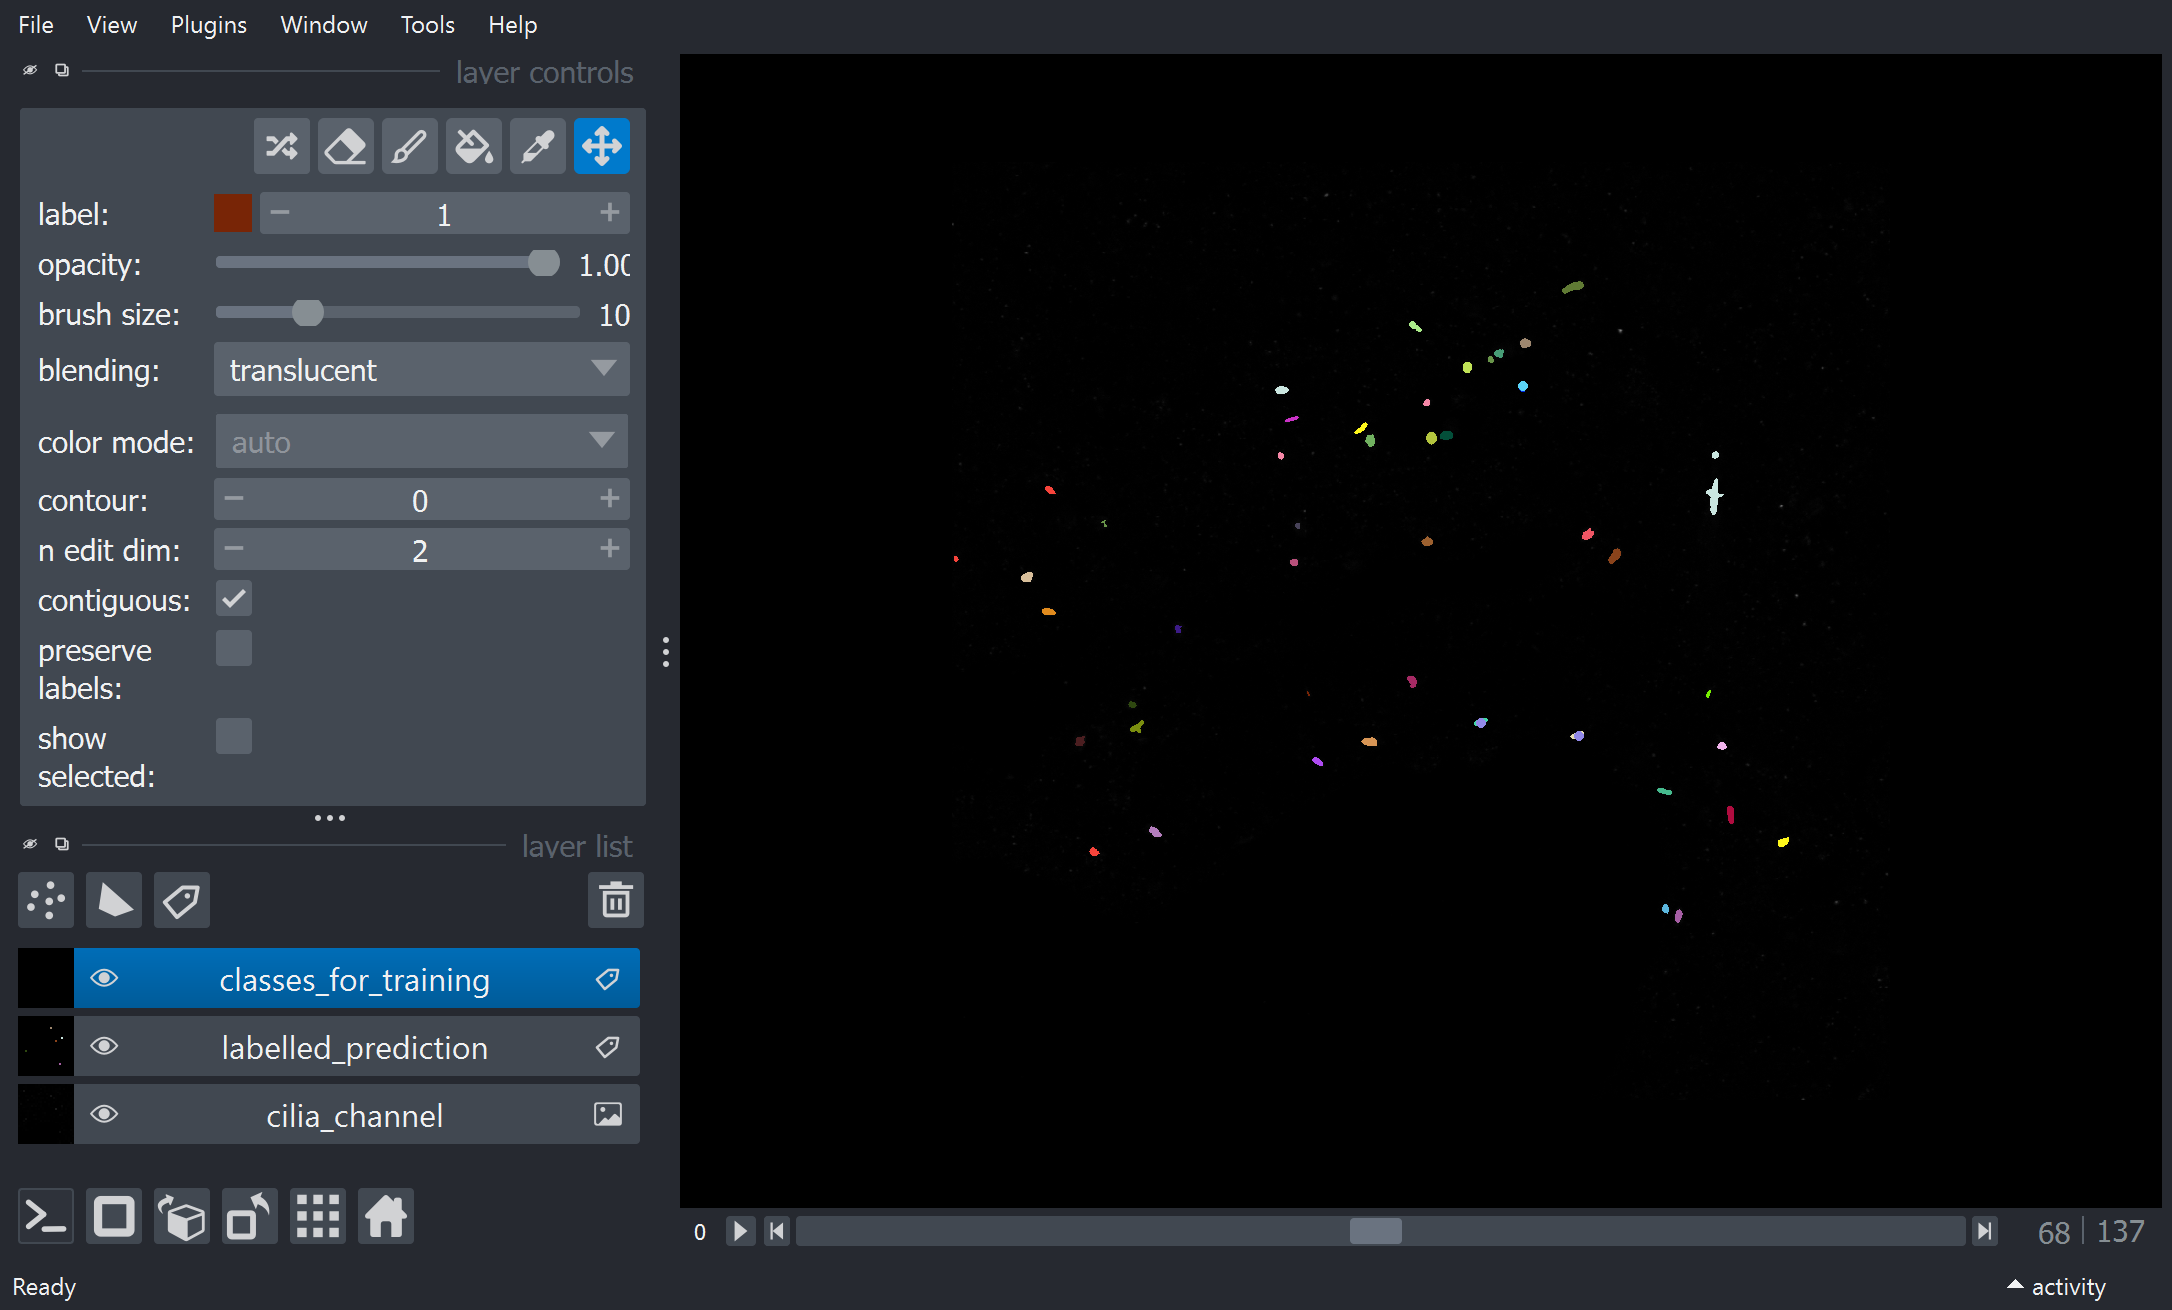

In [2]:
cilia_channel = load_rescaled_channel(
    "../data/20231025_p1_cd13_opn_arl13b.lif", 5, 1
)
classes_for_training = imread("D:/estela/src/classes_for_training.tif")

labelled_prediction = cilia_segmenter_cleaner(cilia_channel)

viewer = napari.Viewer()
viewer.add_image(cilia_channel)
viewer.add_labels(labelled_prediction, opacity=1)
viewer.add_labels(classes_for_training, opacity=1)
napari.utils.nbscreenshot(viewer)

In [3]:
df = cilia_props_table(labelled_prediction, cilia_channel)
df

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity
0,1,719.0,18.294934,8.525367,174.0,0.896509
1,2,836.0,21.217275,8.022449,126.0,0.875393
2,3,745.0,17.743137,8.152563,133.0,0.856322
3,4,586.0,22.383497,6.891721,125.0,0.733417
4,5,457.0,20.226941,4.132921,67.0,0.889105
...,...,...,...,...,...,...
414,415,892.0,21.464908,8.126919,105.0,0.891109
415,416,487.0,14.374873,7.878321,146.0,0.915414
416,417,706.0,19.703986,7.835110,190.0,0.860976
417,418,918.0,21.869120,8.755774,171.0,0.886100


In [4]:
def parse_classes(class_number):
    if class_number == 1:
        return "elongated"
    elif class_number == 2:
        return "looped"
    elif class_number == 3:
        return "fibroblastic"
    elif class_number == 0:
        return "NA"
    else:
        raise ValueError

In [5]:
props = regionprops_table(
    labelled_prediction,
    classes_for_training,
    properties=["label", "intensity_max"],
)
data_classes = pd.DataFrame(props).rename(columns={"intensity_max": "classes"})
data_classes["classes"] = data_classes["classes"].apply(parse_classes)
data_classes

,label,classes
0,1,NA
1,2,NA
2,3,NA
3,4,NA
4,5,NA
...,...,...
414,415,NA
415,416,NA
416,417,NA
417,418,NA


In [6]:
complete_dataset = df.merge(right=data_classes, on="label")
complete_dataset

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity,classes
0,1,719.0,18.294934,8.525367,174.0,0.896509,NA
1,2,836.0,21.217275,8.022449,126.0,0.875393,NA
2,3,745.0,17.743137,8.152563,133.0,0.856322,NA
3,4,586.0,22.383497,6.891721,125.0,0.733417,NA
4,5,457.0,20.226941,4.132921,67.0,0.889105,NA
...,...,...,...,...,...,...,...
414,415,892.0,21.464908,8.126919,105.0,0.891109,NA
415,416,487.0,14.374873,7.878321,146.0,0.915414,NA
416,417,706.0,19.703986,7.835110,190.0,0.860976,NA
417,418,918.0,21.869120,8.755774,171.0,0.886100,NA


c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lab\.conda\envs\cilia\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

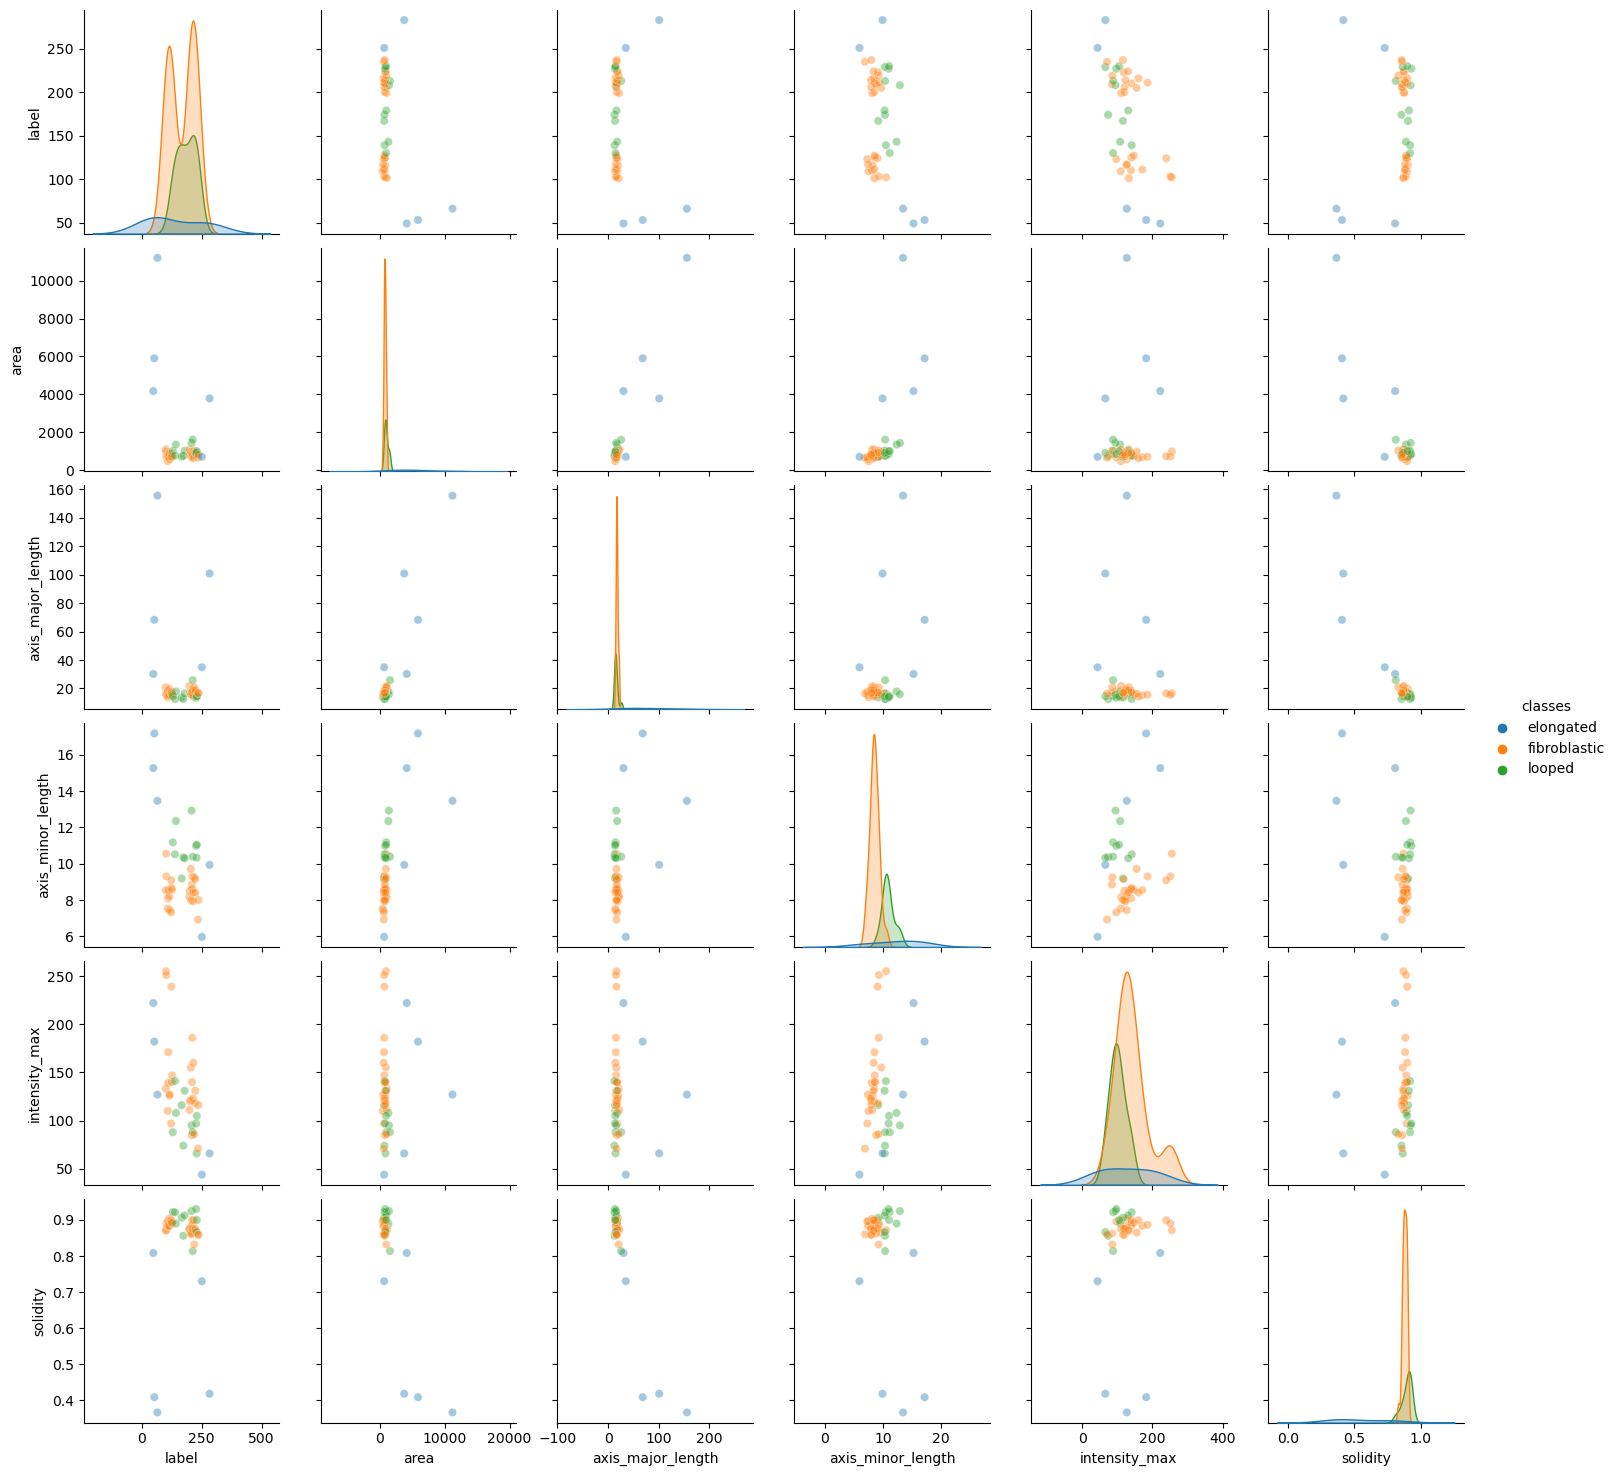

In [7]:
sns.pairplot(
    complete_dataset.query("classes != 'NA'").query("area < 25000"),
    hue="classes",
    plot_kws={"alpha": 0.4},
)

In [8]:
df_classes = complete_dataset.query("classes != 'NA'")
df_classes

,label,area,axis_major_length,axis_minor_length,intensity_max,solidity,classes
34,35,39813.0,429.433278,25.159312,115.0,0.051629,elongated
48,49,4168.0,30.162711,15.269550,222.0,0.808065,elongated
52,53,5898.0,68.186962,17.178962,182.0,0.408647,elongated
65,66,11205.0,155.472597,13.465924,127.0,0.366488,elongated
100,101,1090.0,20.850605,8.530031,133.0,0.870607,fibroblastic
101,102,981.0,16.612612,10.554903,255.0,0.871226,fibroblastic
102,103,709.0,15.524609,9.307649,251.0,0.889586,fibroblastic
108,109,461.0,13.685378,7.532451,110.0,0.896887,fibroblastic
109,110,766.0,18.290562,8.084058,139.0,0.883506,fibroblastic
110,111,675.0,15.114198,8.543279,171.0,0.883508,fibroblastic


In [11]:
X = df_classes[["solidity", "axis_minor_length"]]
y = df_classes["classes"]

scaler = StandardScaler()
scaler = scaler.fit(X)
scaled_features = scaler.transform(X)
X[["scaled_solidity", "scaled_axis_minor_length"]] = pd.DataFrame(
    scaled_features, index=X.index, columns=X.columns
)
X

C:\Users\Lab\AppData\Local\Temp\ipykernel_10116\1596906167.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["scaled_solidity", "scaled_axis_minor_length"]] = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
C:\Users\Lab\AppData\Local\Temp\ipykernel_10116\1596906167.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["scaled_solidity", "scaled_axis_minor_length"]] = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)


,solidity,axis_minor_length,scaled_solidity,scaled_axis_minor_length
34,0.051629,25.159312,-4.438972,4.810570
48,0.808065,15.269550,-0.096727,1.683594
52,0.408647,17.178962,-2.389548,2.287318
65,0.366488,13.465924,-2.631557,1.113318
100,0.870607,8.530031,0.262288,-0.447329
101,0.871226,10.554903,0.265839,0.192902
102,0.889586,9.307649,0.371235,-0.201459
108,0.896887,7.532451,0.413147,-0.762747
109,0.883506,8.084058,0.336335,-0.588338
110,0.883508,8.543279,0.336344,-0.443140


In [25]:
scaled_features = X.filter(
    ["scaled_solidity", "scaled_axis_minor_length"], axis=1
)
scaled_features

,scaled_solidity,scaled_axis_minor_length
34,-4.438972,4.810570
48,-0.096727,1.683594
52,-2.389548,2.287318
65,-2.631557,1.113318
100,0.262288,-0.447329
101,0.265839,0.192902
102,0.371235,-0.201459
108,0.413147,-0.762747
109,0.336335,-0.588338
110,0.336344,-0.443140


In [26]:
neigh = {}

In [27]:
neigh["uniform_3"] = KNeighborsClassifier(n_neighbors=3)
neigh["uniform_3"].fit(scaled_features, y)

KNeighborsClassifier(n_neighbors=3)

In [28]:
neigh["uniform_5"] = KNeighborsClassifier(n_neighbors=5)
neigh["uniform_5"].fit(scaled_features, y)

KNeighborsClassifier()

In [29]:
def get_color(kind):
    if kind == "elongated":
        return 1
    elif kind == "fibroblastic":
        return 2
    elif kind == "looped":
        return 3
    else:
        return 4

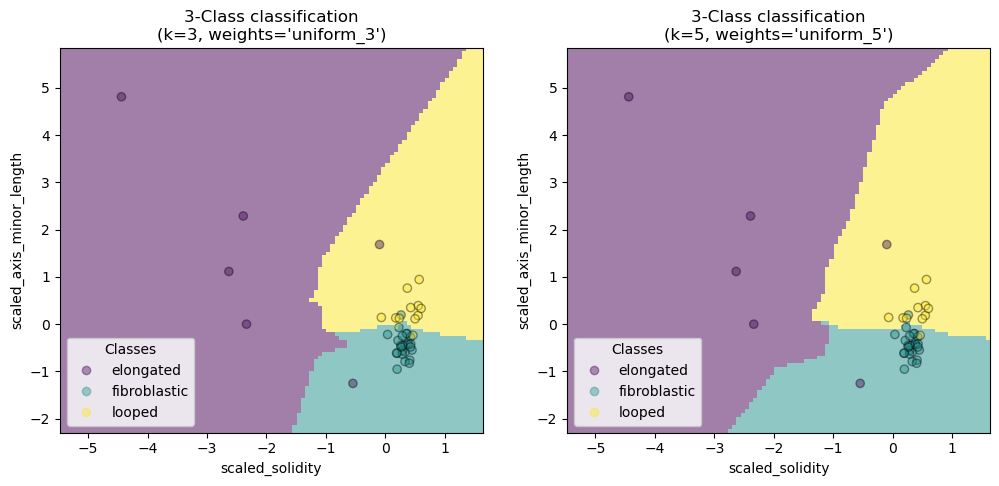

In [30]:
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform_3", "uniform_5")):
    disp = DecisionBoundaryDisplay.from_estimator(
        neigh[weights],
        scaled_features,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=scaled_features.columns[0],
        ylabel=scaled_features.columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        scaled_features.iloc[:, 0],
        scaled_features.iloc[:, 1],
        c=y.apply(get_color),
        edgecolors="k",
        alpha=0.4,
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        np.unique(y),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={neigh[weights].n_neighbors}, weights={weights!r})"
    )

plt.show()

Since one of the values corresponding as the elongated is wrongly classified as looped. We are going to try to correct that by using distance as another parameter for the classification.

In [31]:
neigh["distance_3"] = KNeighborsClassifier(n_neighbors=3, weights="distance")
neigh["distance_3"].fit(scaled_features, y)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [32]:
neigh["distance_5"] = KNeighborsClassifier(n_neighbors=5, weights="distance")
neigh["distance_5"].fit(scaled_features, y)

KNeighborsClassifier(weights='distance')

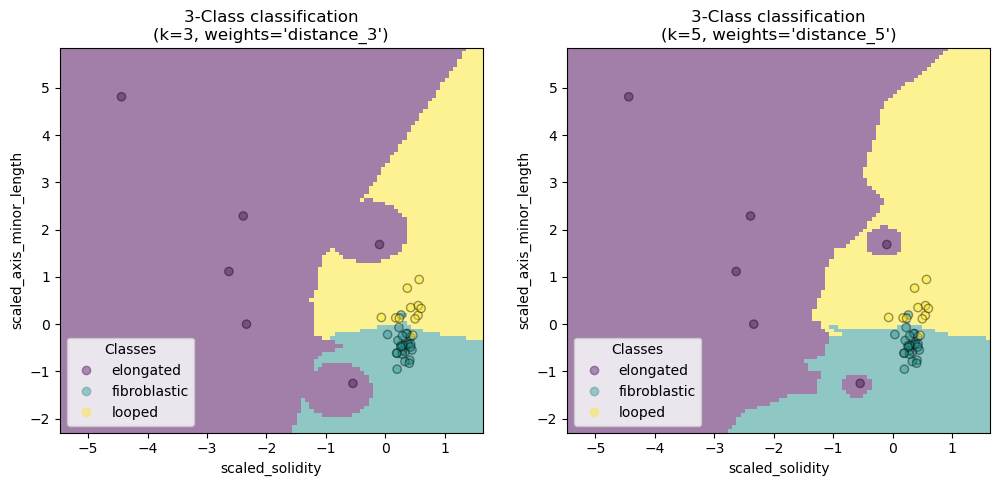

In [33]:
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("distance_3", "distance_5")):
    disp = DecisionBoundaryDisplay.from_estimator(
        neigh[weights],
        scaled_features,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=scaled_features.columns[0],
        ylabel=scaled_features.columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        scaled_features.iloc[:, 0],
        scaled_features.iloc[:, 1],
        c=y.apply(get_color),
        edgecolors="k",
        alpha=0.4,
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        np.unique(y),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={neigh[weights].n_neighbors}, weights={weights!r})"
    )

plt.show()

n=3 seems to be the one working the best

## Saving scaler and classifer

In [34]:
joblib.dump(scaler, "D:/estela/results/20240410/scaler.sca")

['D:/estela/results/20240410/scaler.sca']

In [35]:
joblib.dump(
    neigh["distance_3"], "D:/estela/results/20240410/cilia_classifier.ml"
)

['D:/estela/results/20240410/cilia_classifier.ml']

To open both the scaler and classifier the following is used:

In [43]:
# scaler = joblib.load('D:/estela/results/20240410/scaler.bin')

In [42]:
# cilia_classifier = joblib.load('D:/estela/results/20240410/cilia_classifier.bin')